# Combining Image Frequencies

In [1]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as img
from scipy import signal

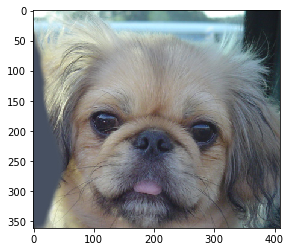

In [19]:
img_cat = cv2.imread('./resources/cat.jpg') 
img_dog = cv2.imread('./resources/dog.jpg') 
img_cat = cv2.cvtColor(src=img_cat, code=cv2.COLOR_BGR2RGB) 
img_dog = cv2.cvtColor(src=img_dog, code=cv2.COLOR_BGR2RGB)
img_dog_correspondances = [[185.0,119.0], [200.0, 282.0],[299.0,191.0]]
img_cat_correspondances = [[193.0,126.5],[192.0,277.5],[296.0,199.5]]

plt.imshow(img_dog)

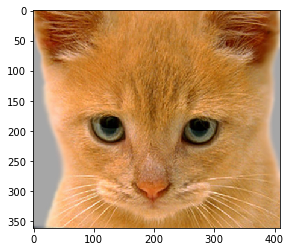

In [20]:
plt.imshow(img_cat)

## Cross-Correlation 2D

In [3]:
def cross_correlation_2d_1channel(img, kernel):
    #Size of the kernel
    k_x = kernel.shape[1]
    k_y = kernel.shape[0]
    
    X = img.shape[1]
    Y = img.shape[0]
    
    padding_y = int((k_y - 1)/2)
    padding_x = int((k_x - 1)/2)
    
    #Zero padding
    image_padded = np.zeros((Y + 2 * padding_y  , X + 2 * padding_x))
    image_padded[padding_y:-padding_y, padding_x:-padding_x] = img
    
    #Create matrix to store result of convolution, same size as original image
    result = np.zeros((Y, X))
    
    #Iterate on X and Y directions and perform element-wise operation
    for x in range(X):
        for y in range(Y):
            result[y, x] = (kernel * image_padded[y: y+k_y, x: x+k_x]).sum()

    return result

In [4]:
def cross_correlation_2d(img, kernel):
    output = np.zeros(img.shape)
    
    if img.ndim == 2:
        output = cross_correlation_2d_1channel(img, kernel)
    elif img.ndim == 3:
        for i in range(img.shape[2]):
            img_1channel = img[:,:,i]
            output_1channel = cross_correlation_2d_1channel(img_1channel, kernel)
            output[:,:,i] = output_1channel
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


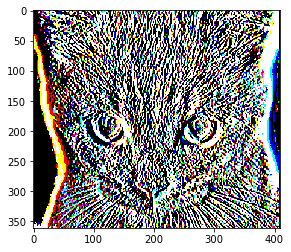

(361, 410, 3)

In [5]:
h = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
filtered_img = cross_correlation_2d(img_cat, h)
plt.imshow(filtered_img)
plt.show()
filtered_img.shape

## Convolve 2D

In [6]:
def convolve_2d_1channel(img, kernel):
    #Flip kernel for convolution
    kernel = np.flipud(np.fliplr(kernel))
    
    #Call cross correlation with flipped kernel
    result = cross_correlation_2d(img, kernel)
    
    return result

In [7]:
def convolve_2d(img, kernel):
    output = np.zeros(img.shape)
    
    if img.ndim == 2:
        output = convolve_2d_1channel(img, kernel)
    elif img.ndim == 3:
        for i in range(img.shape[2]):
            img_1channel = img[:,:,i]
            output_1channel = convolve_2d_1channel(img_1channel, kernel)
            output[:,:,i] = output_1channel
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


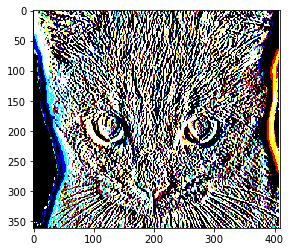

(361, 410, 3)

In [8]:
h = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
filtered_img = convolve_2d(img_cat, h)
plt.imshow(filtered_img)
plt.show()
filtered_img.shape

## Gaussian Blur

In [9]:
def gaussian_blur_kernel_2d(sigma, height, width):
    #Create x and y based on width and height of the kernel
    y = np.linspace(-(height - 1) / 2, (height - 1) / 2, height)
    x = np.linspace(-(width - 1) / 2, (width - 1) / 2, width)
    
    #Compute 1D gaussian 
    kernel_y = np.exp(-0.5 * np.square(y) / np.square(sigma))
    kernel_x = np.exp(-0.5 * np.square(x) / np.square(sigma))
    
    #Compute outer product to get 2D Gaussian kernel
    kernel = np.outer(kernel_y, kernel_x)
    
    #Divide by the sum of its elements
    kernel = kernel/np.sum(kernel)
    
    return kernel

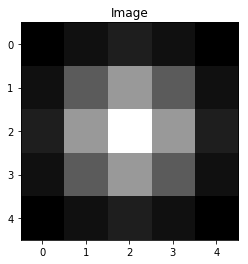

In [10]:
h = gaussian_blur_kernel_2d(1, 5, 5)
plt.imshow(h, interpolation='none',cmap='gray')
plt.title("Image")
plt.show()

## Low-pass

In [11]:
def low_pass(img, sigma, size):
    kernel = gaussian_blur_kernel_2d(sigma, size, size)
    filtered_img = convolve_2d(img, kernel)

    return filtered_img

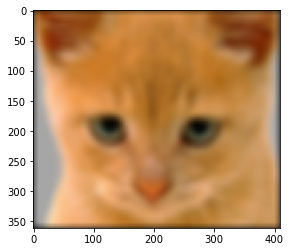

In [12]:
lp_img = low_pass(img_cat, 7, 21)
plt.imshow(lp_img.astype('uint8'))
plt.show()

## High-pass

In [13]:
def high_pass(img, sigma, size):
    lp_image = low_pass(img, sigma, size)
    hp_image = img - lp_image
    return hp_image

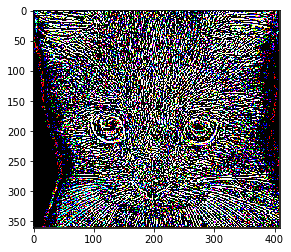

In [14]:
hp_img = high_pass(img_cat, 1, 3)
plt.imshow(hp_img.astype('uint8'))
plt.show()

## Align images

In [15]:
def align_images(img1, img2, img1_correspondances, img2_correspondances):
    left = np.array([[x, y] for y, x in img1_correspondances], np.float32)
    right = np.array([[x, y] for y, x in img2_correspondances], np.float32)
    left_image = img1
    h, w = img1.shape[:2]
    mapping = cv2.getAffineTransform(right, left)
    right_image = cv2.warpAffine(img2, mapping, (w, h), borderMode=cv2.BORDER_REFLECT)
    return left_image, right_image

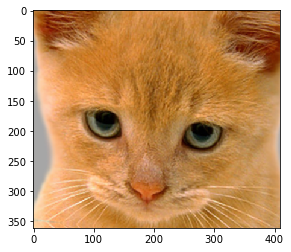

In [16]:
left_image, right_image = align_images(img_dog, img_cat,img_dog_correspondances, img_cat_correspondances)
plt.imshow(right_image)

## Create hybrid Image

In [17]:
def create_hybrid(img1, img2, sigma1, size1, sigma2, size2, mixin_ratio, scale_factor):
    img1 = img1.astype(np.float32) / 255.0
    img2 = img2.astype(np.float32) / 255.0

    lp_img = low_pass(img1, sigma1, size1)
    hp_img = high_pass(img2, sigma2, size2)

    lp_img *=  (1 - mixin_ratio)
    hp_img *= mixin_ratio
    hybrid_img = (lp_img + hp_img) * scale_factor
    return (hybrid_img * 255).clip(0, 255).astype(np.uint8)

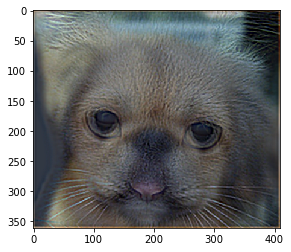

In [18]:
hybrid_image = create_hybrid(left_image, right_image, 7.0, 13, 4.1, 9, 0.65, 2.0)
plt.imshow(hybrid_image)